In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

# CycleGAN

#### Directory structure:
- **data/** contains the datasets.
    - **data/&lt;dataset&gt;/{train_A, train_B}/** contains training images for classes A and B.
    - **data/&lt;dataset&gt;/{test_A, test_B}/** contains testing images that are not used during training. These are useful to evaluate the generalization of the model to new data.
- **images/** stores metadata and loss information of each CycleGAN run, as well as evaluation images.
    - **images/meta_data.json** contains the settings of the run.
    - **images/loss_output.csv** contains the various losses of the model, stored after every batch.
    - **images/{train_A, train_B, test_A, test_B}** contains intermediate evaluation images for each epoch, illustrating generator performance.
    - **images/tmp.png** shows example image translations from the current moment in training. This image updates in real time and can be used to see how the training converges.
- **saved_models** stores the generator and discriminator models resulting from each run, which are saved every 20 epochs.

In [2]:
from keras.layers import Layer, Input, Dropout, Conv2D, Activation, add, UpSampling2D, Conv2DTranspose, Flatten, MaxPooling2D
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Network

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from progress.bar import Bar
import datetime
import time
import json
import csv
import sys
import os

import keras.backend as K
import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

1.14.0


In [3]:
from helper_funcs_mask import *

In [4]:
image_folder = 'brain'
data = load_data(subfolder=image_folder)

In [5]:
opt = {}

# Data
opt['channels'] = data["nr_of_channels"]
opt['img_shape'] = data["image_size"] + (opt['channels'],)
print('Image shape: ', opt['img_shape'])

opt['A_train'] = data["trainA_images"]
opt['B_train'] = data["trainB_images"]
opt['A_test'] = data["testA_images"]
opt['B_test'] = data["testB_images"]
opt['testA_image_names'] = data["testA_image_names"]
opt['testB_image_names'] = data["testB_image_names"]

opt['trainA_image_names'] = data["trainA_image_names"]
opt['trainB_image_names'] = data["trainB_image_names"]

opt['maskA_images'] = data["maskA_images"]
opt['maskB_images'] = data["maskB_images"]
opt['maskA_image_names'] = data["maskA_image_names"]
opt['maskB_image_names'] = data["maskB_image_names"]

#opt['CTFOSCAL_images'] = data["CTFOSCAL_images"]
#opt['CTFOSCAL_image_names'] = data["CTFOSCAL_image_names"]
#opt['CTHEALTHY_images'] = data["CTHEALTHY_images"]
#opt['CTHEALTHY_image_names'] = data["CTHEALTHY_image_names"]

print(opt['A_train'].shape)
print(opt['B_train'].shape)
print(opt['maskA_images'].shape)
print(opt['maskB_images'].shape)

#print(opt['CTFOSCAL_images'].shape)
#print(len(opt['CTFOSCAL_image_names']))
#print(opt['CTHEALTHY_images'].shape)
#print(len(opt['CTHEALTHY_image_names']))

Image shape:  (256, 256, 1)
(502, 256, 256, 1)
(993, 256, 256, 1)
(502, 256, 256, 1)
(993, 256, 256, 1)


In [6]:
#opt['paired_data'] = True
opt['paired_data'] = False

In [7]:
# Training parameters
opt['lambda_ABA'] = 10.0  # Cyclic loss weight A_2_B
opt['lambda_BAB'] = 10.0  # Cyclic loss weight B_2_A
opt['lambda_adversarial'] = 1.0  # Weight for loss from discriminator guess on synthetic images
opt['learning_rate_D'] = 2e-4
opt['learning_rate_G'] = 2e-4
opt['generator_iterations'] = 3  # Number of generator training iterations in each training loop
opt['discriminator_iterations'] = 1  # Number of discriminator training iterations in each training loop
opt['synthetic_pool_size'] = 50  # Size of image pools used for training the discriminators
opt['beta_1'] = 0.5  # Adam parameter
opt['beta_2'] = 0.999  # Adam parameter
opt['batch_size'] = 8  # Number of images per batch
opt['epochs'] = 1  # Choose multiples of 20 since the models are saved each 20th epoch

In [8]:
# Output parameters
opt['save_models'] = True  # Save or not the generator and discriminator models
opt['save_training_img'] = True  # Save or not example training results or only tmp.png
opt['save_training_img_interval'] = 1  # Number of epoch between saves of intermediate training results
opt['self.tmp_img_update_frequency'] = 3  # Number of batches between updates of tmp.png

In [9]:
# Architecture parameters
opt['use_instance_normalization'] = True  # Use instance normalization or batch normalization
opt['use_dropout'] = False  # Dropout in residual blocks
opt['use_bias'] = True  # Use bias
opt['use_linear_decay'] = True  # Linear decay of learning rate, for both discriminators and generators
opt['decay_epoch'] = 100  # The epoch where the linear decay of the learning rates start
opt['use_patchgan'] = True  # PatchGAN - if false the discriminator learning rate should be decreased
opt['use_resize_convolution'] = False  # Resize convolution - instead of transpose convolution in deconvolution layers (uk) - can reduce checkerboard artifacts but the blurring might affect the cycle-consistency
opt['discriminator_sigmoid'] = True  # Add a final sigmoid activation to the discriminator

In [10]:
# Tweaks
opt['REAL_LABEL'] = 1.0  # Use e.g. 0.9 to avoid training the discriminators to zero loss

In [11]:
# Discriminator layers
def ck(model, opt, x, k, use_normalization, use_bias):
    x = Conv2D(filters=k, kernel_size=4, strides=2, padding='same', use_bias=use_bias)(x)
    if use_normalization:
        x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# First generator layer
def c7Ak(model, opt, x, k):
    x = Conv2D(filters=k, kernel_size=7, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Downsampling
def dk(model, opt, x, k):  # Should have reflection padding
    x = Conv2D(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Residual block
def Rk(model, opt, x0):
    k = int(x0.shape[-1])

    # First layer
    x = ReflectionPadding2D((1,1))(x0)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)

    if opt['use_dropout']:
        x = Dropout(0.5)(x)

    # Second layer
    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    # Merge
    x = add([x, x0])

    return x

# Upsampling
def uk(model, opt, x, k):
    # (up sampling followed by 1x1 convolution <=> fractional-strided 1/2)
    if opt['use_resize_convolution']:
        x = UpSampling2D(size=(2, 2))(x)  # Nearest neighbor upsampling
        x = ReflectionPadding2D((1, 1))(x)
        x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    else:
        x = Conv2DTranspose(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)  # this matches fractionally stided with stride 1/2
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

#### Architecture functions

In [12]:
def build_discriminator(model, opt, name=None):
    # Input
    input_img = Input(shape=opt['img_shape'])

    # Layers 1-4
    x = ck(model, opt, input_img, 64, False, True) #  Instance normalization is not used for this layer)
    x = ck(model, opt, x, 128, True, opt['use_bias'])
    x = ck(model, opt, x, 256, True, opt['use_bias'])
    x = ck(model, opt, x, 512, True, opt['use_bias'])

    # Layer 5: Output
    if opt['use_patchgan']:
        x = Conv2D(filters=1, kernel_size=4, strides=1, padding='same', use_bias=True)(x)
    else:
        x = Flatten()(x)
        x = Dense(1)(x)

    if opt['discriminator_sigmoid']:
        x = Activation('sigmoid')(x)

    return Model(inputs=input_img, outputs=x, name=name)

def build_generator(model, opt, name=None):
    # Layer 1: Input
    input_img = Input(shape=opt['img_shape'])
    x = ReflectionPadding2D((3, 3))(input_img)
    x = c7Ak(model, opt, x, 32)

    # Layer 2-3: Downsampling
    x = dk(model, opt, x, 64)
    x = dk(model, opt, x, 128)

    # Layers 4-12: Residual blocks
    for _ in range(4, 13):
        x = Rk(model, opt, x)

    # Layer 13:14: Upsampling
    x = uk(model, opt, x, 64)
    x = uk(model, opt, x, 32)

    # Layer 15: Output
    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(opt['channels'], kernel_size=7, strides=1, padding='valid', use_bias=True)(x)
    x = Activation('tanh')(x)

    return Model(inputs=input_img, outputs=x, name=name)

#### CasNet generator

# Santiago

In [13]:
#@title Generator
from keras import layers

def u_block(input_tensor, 
            encoder_num_filters=[64, 128, 256, 512, 512, 512, 512, 512],
            decoder_num_filters=[512, 1024, 1024, 1024, 1024, 512, 256, 128],
            use_instance_norm=True,
            block_prefix=''):
    
    x = input_tensor
    encoder_blocks_outputs = []
    
    # Encoder path.
    for i, num_filters in enumerate(encoder_num_filters):
        x = layers.Conv2D(num_filters, 
                          kernel_size=4, 
                          strides=2, 
                          padding='same', 
                          name=f'{block_prefix}_EncoderBlock{i+1}-Conv')(x)
        if use_instance_norm:
            x = InstanceNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Instancenorm')(x)
        else:
            x = layers.BatchNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Batchnorm')(x)
        x = layers.Activation('relu', name=f'{block_prefix}_EncoderBlock{i+1}-ReLU')(x)
        
        # Append the encoder blocks outputs, except for the last one.
        if i != len(encoder_num_filters) - 1: 
            encoder_blocks_outputs.append(x)

    # Decoder path.
    for i, num_filters in enumerate(decoder_num_filters):
        x = layers.Conv2DTranspose(
            num_filters, 
            kernel_size=(4, 4), 
            strides=(2, 2), 
            padding='same',
            name=f'{block_prefix}_DecoderBlock{i+1}-TransposedConv'
        )(x)
        x = layers.Activation('relu', name=f'{block_prefix}_DecoderBlock{i+1}-ReLU')(x)

        # All the decoder blocks have concatenate the encoder block output with
        # the same spatial dimentions except for the last one.
        if i != len(decoder_num_filters) - 1: 
            x = layers.Concatenate(
                name=f'{block_prefix}_DecoderBlock{i+1}-Concat'
            )([encoder_blocks_outputs[-(i + 1)], x])

    # Last operation: 1x1 conv to map the image to the input n_channels.
    x = layers.Conv2D(1,   #input_tensor.shape[-1]
                      kernel_size=(1, 1), 
                      name=f'{block_prefix}_Decoder-Conv1x1')(x)
    output = layers.Activation('tanh', name=f'{block_prefix}_Decoder-Tanh')(x)

    return output

def build_casnet_generator(input_shape=(256, 256, 1), 
                           n_blocks=1, 
                           use_instance_norm=True,
                           name=None):
    """Create a CasNet Generator using UBlocks"""
    input_tensor = Input(shape=input_shape)
    x = input_tensor
    for i in range(n_blocks):
        x = u_block(x, block_prefix=f'UBlock{i+1}', use_instance_norm=use_instance_norm)
    
    return Model(inputs=input_tensor, outputs=x, name=name)

# functions for the convolutional encoder.

def residual_block(x, filters, pooling=False, name='ResBlock'):
    residual = x
    x = Conv2D(filters, 3, activation="relu", padding="same", name=f'{name}_conv1')(x)
    x = Conv2D(filters, 3, activation="relu", padding="same", name=f'{name}_conv2')(x)
    if pooling:
        x = MaxPooling2D(2, padding="same", name=f'{name}_maxpool')(x)
        residual = Conv2D(filters, 1, strides=2, name=f'{name}_conv3')(residual)
    elif filters != residual.shape[-1]:
        residual = Conv2D(filters, 1, name=f'{name}_conv3')(residual)
    x = add([x, residual], name=f'{name}_res')
    return x


def conv_encoder(input_shape=(256, 256, 1), n_blocks=3, name='ConvEncoder'):
    inputs = x = Input(shape=input_shape, name=f'{name}_input')
    for i in range(n_blocks):
        x = residual_block(x, filters=2**(6+i), pooling=False, name=f'{name}_block_{i}')
    #ggarzon
    x = Conv2D(1, 3, activation="relu", padding="same", name=f'{name}_finalb')(x)
    return Model(inputs=inputs, outputs=x)

In [14]:
# Model creation.
def build_conditioned_casnet_generator(input_shape=(256, 256, 1), res_blocks=3, u_blocks=1, name=''):
    
    # Creation of the conv encoders for the image and mask.
    ct_encoder = conv_encoder(input_shape=opt['img_shape'], n_blocks=res_blocks, name='ct')
    mask_encoder = conv_encoder(input_shape=opt['img_shape'], n_blocks=res_blocks, name='mask')
    
    # Concatenation of the features from the encoders.
    #feature_fusion = layers.concatenate([ct_encoder.output, mask_encoder.output])
    
    # Suma de embebidos
    feature_fusion = add([ct_encoder.output, mask_encoder.output])
    
    #print(ct_encoder.output.shape)
    #print(mask_encoder.output.shape)
    
    # Passing the fused features to the casnet.
    #numfeats = 2*(2**(5+res_blocks))
    #numfeats = ct_encoder.output.get_shape().as_list()[-1] + mask_encoder.output.get_shape().as_list()[-1]
    numfeats = 1
    casnet = build_casnet_generator(input_shape=(256, 256, numfeats), n_blocks=u_blocks, name="casnet")
    x = casnet(feature_fusion)
    tf.keras.utils.plot_model(casnet, show_shapes=True, to_file='model.png')
    
    # Build the model
    model = Model(inputs=[ct_encoder.input, mask_encoder.input], outputs=x, name=name)
    return model

#### Loss functions
The discriminators use MSE loss. The generators use MSE for the adversarial losses and MAE for the cycle consistency losses.

In [15]:
# Mean squared error
def mse(y_true, y_pred):
    loss = tf.reduce_mean(tf.squared_difference(y_pred, y_true))
    return loss

# Mean absolute error
def mae(y_true, y_pred):
    loss = tf.reduce_mean(tf.abs(y_pred - y_true))
    return loss

#### Build CycleGAN model

In [16]:
model = {}

# Normalization
model['normalization'] = InstanceNormalization

# Optimizers
model['opt_D'] = Adam(opt['learning_rate_D'], opt['beta_1'], opt['beta_2'])
model['opt_G'] = Adam(opt['learning_rate_G'], opt['beta_1'], opt['beta_2'])

# Build discriminators
D_A = build_discriminator(model, opt, name='D_A')
D_B = build_discriminator(model, opt, name='D_B')

# Define discriminator models
image_A = Input(shape=opt['img_shape'])
print(image_A.shape)
image_B = Input(shape=opt['img_shape'])
guess_A = D_A(image_A)
guess_B = D_B(image_B)
model['D_A'] = Model(inputs=image_A, outputs=guess_A, name='D_A_model')
model['D_B'] = Model(inputs=image_B, outputs=guess_B, name='D_B_model')

# Compile discriminator models
loss_weights_D = [0.5]  # 0.5 since we train on real and synthetic images
model['D_A'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)
model['D_B'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)

# Use containers to make a static copy of discriminators, used when training the generators
model['D_A_static'] = Network(inputs=image_A, outputs=guess_A, name='D_A_static_model')
model['D_B_static'] = Network(inputs=image_B, outputs=guess_B, name='D_B_static_model')

# Do not update discriminator weights during generator training
model['D_A_static'].trainable = False
model['D_B_static'].trainable = False

# Build generators
#model['G_A2B'] = build_generator(model, opt, name='G_A2B_model')
#model['G_B2A'] = build_generator(model, opt, name='G_B2A_model')

model['G_A2B'] = build_conditioned_casnet_generator(input_shape=(256, 256, 1), res_blocks=2, u_blocks=1, name='G_A2B_model')
model['G_B2A'] = build_conditioned_casnet_generator(input_shape=(256, 256, 1), res_blocks=2, u_blocks=1, name='G_B2A_model')

#print("G_A2B")
model['G_A2B'].summary()
#print("G_B2A")
#model['G_B2A'].summary()

# Define full CycleGAN model, used for training the generators
real_A = Input(shape=opt['img_shape'], name='real_A')
real_B = Input(shape=opt['img_shape'], name='real_B')

mask_A = Input(shape=opt['img_shape'], name='mask_A')
mask_B = Input(shape=opt['img_shape'], name='mask_B')

synthetic_B = model['G_A2B']([real_A, mask_A])
synthetic_A = model['G_B2A']([real_B, mask_B])

dB_guess_synthetic = model['D_B_static'](synthetic_B)
dA_guess_synthetic = model['D_A_static'](synthetic_A)
reconstructed_A = model['G_B2A']([synthetic_B, mask_A])
reconstructed_B = model['G_A2B']([synthetic_A, mask_B]) # Aca no va maskA, va maskB

# Compile full CycleGAN model
model_outputs = [reconstructed_A, reconstructed_B,
                 dB_guess_synthetic, dA_guess_synthetic]
compile_losses = [mae, mae,
                  mse, mse]
compile_weights = [opt['lambda_ABA'], opt['lambda_BAB'],
                   opt['lambda_adversarial'], opt['lambda_adversarial']]

model['G_model'] = Model(inputs=[real_A, mask_A, real_B, mask_B], # mask_B
                     outputs=model_outputs,
                     name='G_model')

model['G_model'].compile(optimizer=model['opt_G'],
                     loss=compile_losses,
                     loss_weights=compile_weights)

W0425 23:00:01.133291 139932215748416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0425 23:00:01.134728 139932215748416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0425 23:00:01.137938 139932215748416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0425 23:00:01.534292 139932215748416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



(?, 256, 256, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ct_input (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
mask_input (InputLayer)         (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
ct_block_0_conv1 (Conv2D)       (None, 256, 256, 64) 640         ct_input[0][0]                   
__________________________________________________________________________________________________
mask_block_0_conv1 (Conv2D)     (None, 256, 256, 64) 640         mask_input[0][0]                 
____________________________________________________________________________________________

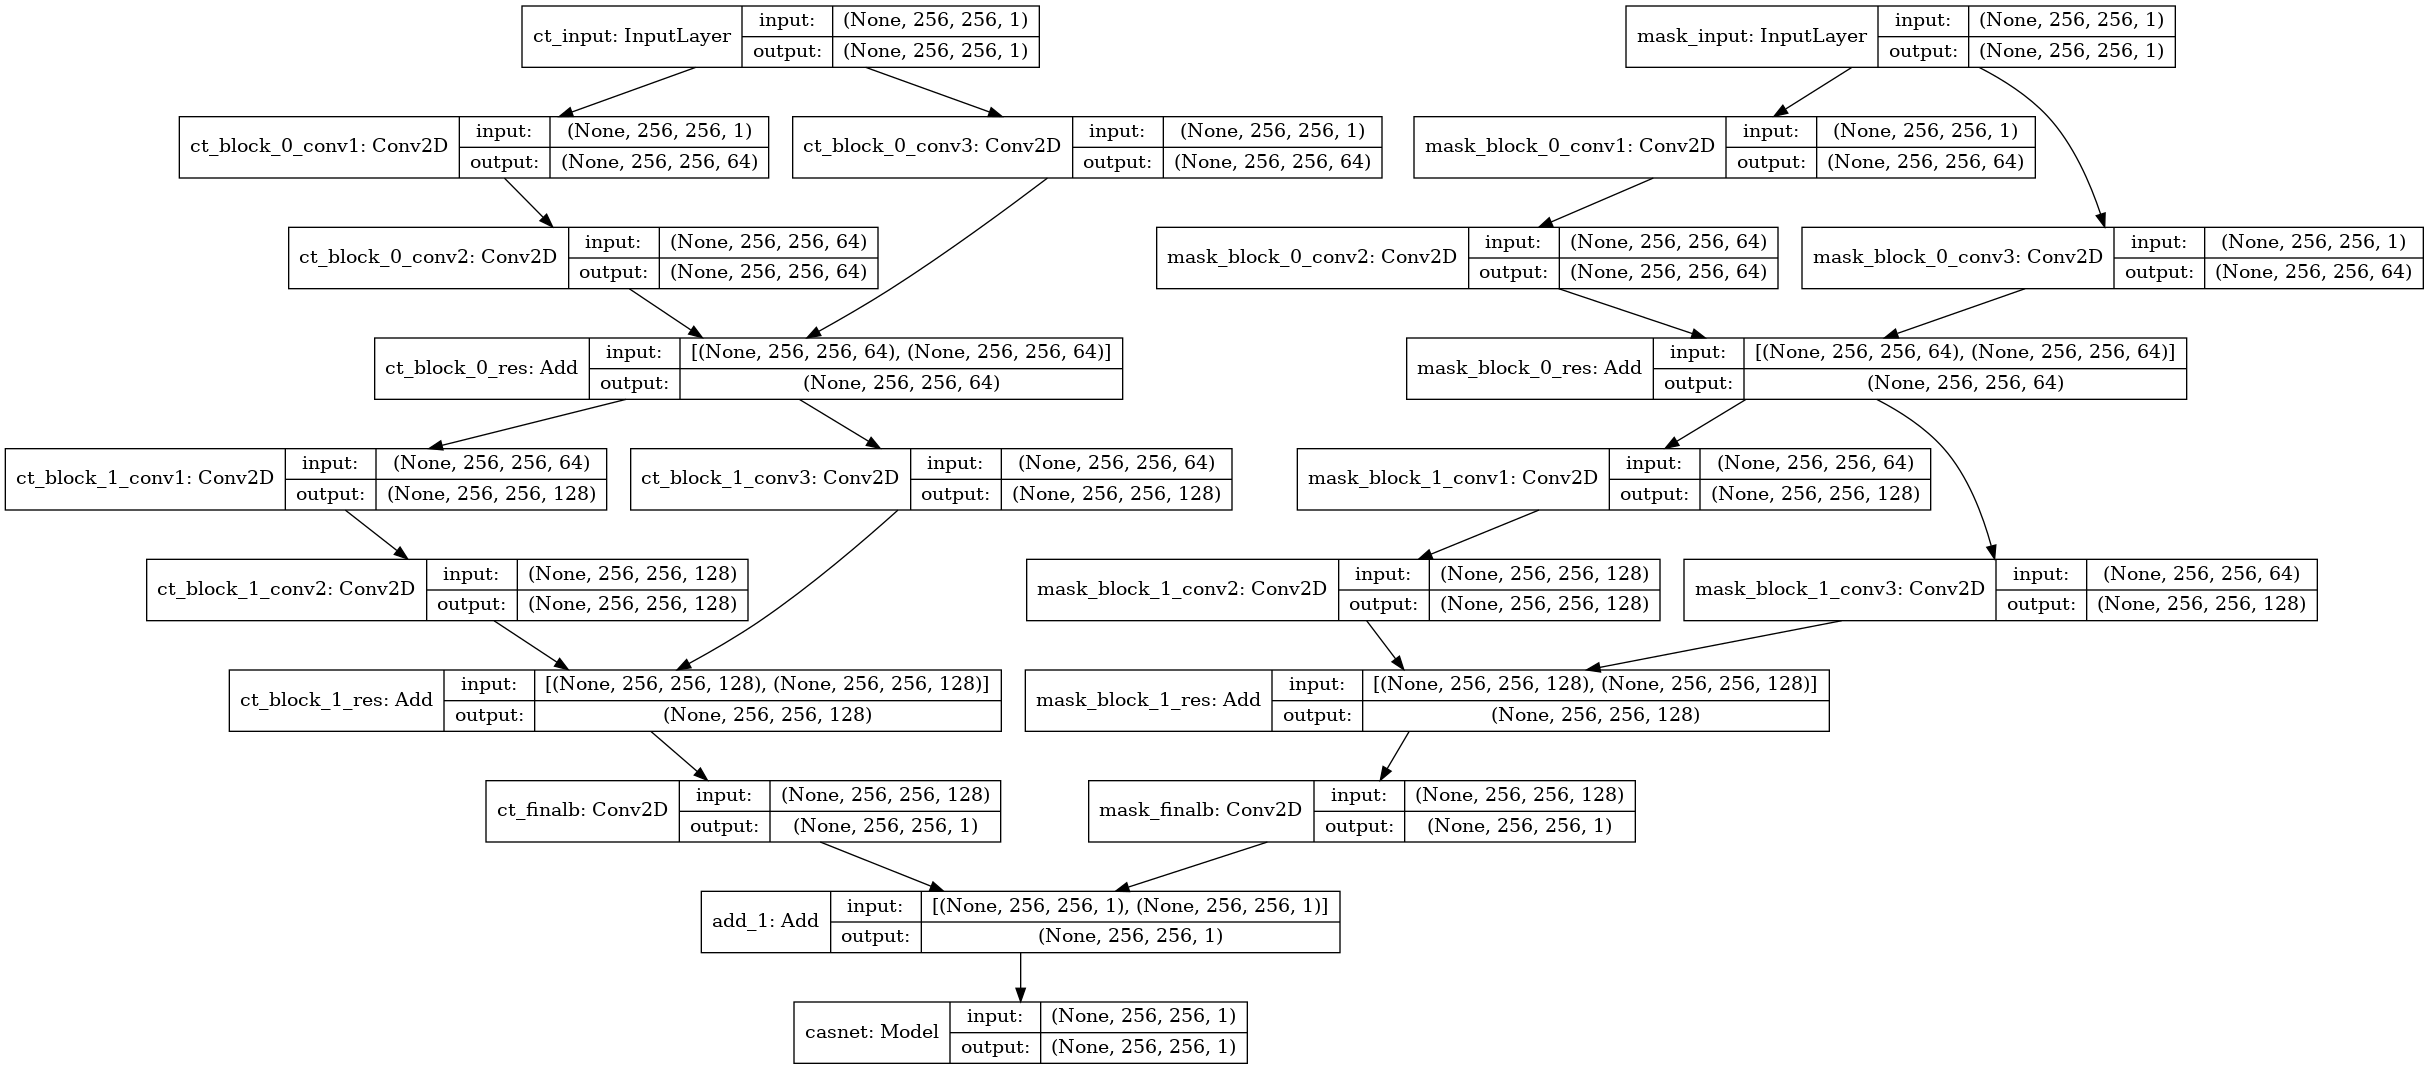

In [17]:
tf.keras.utils.plot_model(model["G_A2B"], show_shapes=True)

#### Folders and configuration

In [ ]:
opt['date_time'] = time.strftime('%Y%m%d-%H%M%S', time.localtime()) + '-' + image_folder

# Output folder for run data and images
opt['out_dir'] = os.path.join('images', opt['date_time'])
if not os.path.exists(opt['out_dir']):
    os.makedirs(opt['out_dir'])

# Output folder for saved models
if opt['save_models']:
    opt['model_out_dir'] = os.path.join('saved_models', opt['date_time'])
    if not os.path.exists(opt['model_out_dir']):
        os.makedirs(opt['model_out_dir'])

write_metadata_to_JSON(model, opt)

# Don't pre-allocate GPU memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

### Training function

In [ ]:
def train(model, opt):

    def run_training_batch():

        # ======= Discriminator training ======
        # Generate batch of synthetic images
        synthetic_images_B = model['G_A2B'].predict([real_images_A, real_mask_B])
        synthetic_images_A = model['G_B2A'].predict([real_images_B, real_mask_A])
        synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
        synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)

        # Train discriminators on batch
        D_loss = []
        for _ in range(opt['discriminator_iterations']):
            D_A_loss_real = model['D_A'].train_on_batch(x=real_images_A, y=ones)
            D_B_loss_real = model['D_B'].train_on_batch(x=real_images_B, y=ones)
            D_A_loss_synthetic = model['D_A'].train_on_batch(x=synthetic_images_A, y=zeros)
            D_B_loss_synthetic = model['D_B'].train_on_batch(x=synthetic_images_B, y=zeros)
            D_A_loss = D_A_loss_real + D_A_loss_synthetic
            D_B_loss = D_B_loss_real + D_B_loss_synthetic
            D_loss.append(D_A_loss + D_B_loss)

        # ======= Generator training ==========
        target_data = [real_images_A, real_images_B, ones, ones]  # Reconstructed images need to match originals, discriminators need to predict ones
        #target_data = [[real_images_A, real_mask_A], [real_images_B, real_mask_B], ones, ones]  # Reconstructed images need to match originals, discriminators need to predict ones

        # Train generators on batch
        G_loss = []
        for _ in range(opt['generator_iterations']):
            G_loss.append(model['G_model'].train_on_batch(
                x=[real_images_A, real_mask_A, real_images_B, real_mask_B], y=target_data))
                #x=[[real_images_A, real_mask_A], [real_images_B, real_mask_B]], y=target_data))

        # =====================================

        # Update learning rates
        if opt['use_linear_decay'] and epoch >= opt['decay_epoch']:
            update_lr(model['D_A'], decay_D)
            update_lr(model['D_B'], decay_D)
            update_lr(model['G_model'], decay_G)

        # Store training losses
        D_A_losses.append(D_A_loss)
        D_B_losses.append(D_B_loss)
        D_losses.append(D_loss[-1])

        ABA_reconstruction_loss = G_loss[-1][1]
        BAB_reconstruction_loss = G_loss[-1][2]
        reconstruction_loss = ABA_reconstruction_loss + BAB_reconstruction_loss
        G_AB_adversarial_loss = G_loss[-1][3]
        G_BA_adversarial_loss = G_loss[-1][4]

        ABA_reconstruction_losses.append(ABA_reconstruction_loss)
        BAB_reconstruction_losses.append(BAB_reconstruction_loss)
        reconstruction_losses.append(reconstruction_loss)
        G_AB_adversarial_losses.append(G_AB_adversarial_loss)
        G_BA_adversarial_losses.append(G_BA_adversarial_loss)
        G_losses.append(G_loss[-1][0])

        # Print training status
        print('\n')
        print('Epoch ---------------------', epoch, '/', opt['epochs'])
        print('Loop index ----------------', loop_index + 1, '/', nr_im_per_epoch)
        if opt['discriminator_iterations'] > 1:
            print('  Discriminator losses:')
            for i in range(opt['discriminator_iterations']):
                print('D_loss', D_loss[i])
        if opt['generator_iterations'] > 1:
            print('  Generator losses:')
            for i in range(opt['generator_iterations']):
                print('G_loss', G_loss[i])
        print('  Summary:')
        print('D_lr:', K.get_value(model['D_A'].optimizer.lr))
        print('G_lr', K.get_value(model['G_model'].optimizer.lr))
        print('D_loss: ', D_loss[-1])
        print('G_loss: ', G_loss[-1][0])
        print('reconstruction_loss: ', reconstruction_loss)
        print_ETA(opt, start_time, epoch, nr_im_per_epoch, loop_index)
        sys.stdout.flush()

        print("loop_index:", loop_index) #GGARZON
        #if loop_index % 3*opt['batch_size'] == 0:
        if loop_index % 1 == 0:
            # Save temporary images continously
            save_tmp_images(model, opt, real_images_A[0], real_images_B[0],
                                 synthetic_images_A[0], synthetic_images_B[0])

    # ======================================================================
    # Begin training
    # ======================================================================
    if opt['save_training_img'] and not os.path.exists(os.path.join(opt['out_dir'], 'train_A')):
        os.makedirs(os.path.join(opt['out_dir'], 'train_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'train_B'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_B'))

    D_A_losses = []
    D_B_losses = []
    D_losses = []

    ABA_reconstruction_losses = []
    BAB_reconstruction_losses = []
    reconstruction_losses = []
    G_AB_adversarial_losses = []
    G_BA_adversarial_losses = []
    G_losses = []

    # Image pools used to update the discriminators
    synthetic_pool_A = ImagePool(opt['synthetic_pool_size'])
    synthetic_pool_B = ImagePool(opt['synthetic_pool_size'])

    # Labels used for discriminator training
    label_shape = (opt['batch_size'],) + model['D_A'].output_shape[1:]
    ones = np.ones(shape=label_shape) * opt['REAL_LABEL']
    zeros = ones * 0

    # Linear learning rate decay
    if opt['use_linear_decay']:
        decay_D, decay_G = get_lr_linear_decay_rate(opt)

    nr_train_im_A = opt['A_train'].shape[0]
    nr_train_im_B = opt['B_train'].shape[0]
    nr_im_per_epoch = int(np.ceil(np.max((nr_train_im_A, nr_train_im_B)) / opt['batch_size']) * opt['batch_size'])

    # Start stopwatch for ETAs
    start_time = time.time()
    timer_started = False

    for epoch in range(1, opt['epochs'] + 1):
        # random_order_A = np.random.randint(nr_train_im_A, size=nr_im_per_epoch)
        # random_order_B = np.random.randint(nr_train_im_B, size=nr_im_per_epoch)

        random_order_A = np.concatenate((np.random.permutation(nr_train_im_A),
                                         np.random.randint(nr_train_im_A, size=nr_im_per_epoch - nr_train_im_A)))
        random_order_B = np.concatenate((np.random.permutation(nr_train_im_B),
                                         np.random.randint(nr_train_im_B, size=nr_im_per_epoch - nr_train_im_B)))

        # Train on image batch
        for loop_index in range(0, nr_im_per_epoch, opt['batch_size']):
            indices_A = random_order_A[loop_index:loop_index + opt['batch_size']]
            indices_B = random_order_B[loop_index:loop_index + opt['batch_size']]

            real_images_A = opt['A_train'][indices_A]
            real_images_B = opt['B_train'][indices_B]
            
            real_mask_A = opt['maskA_images'][indices_A]
            real_mask_B = opt['maskB_images'][indices_B]

            # Train on image batch
            run_training_batch()

            # Start timer after first (slow) iteration has finished
            if not timer_started:
                start_time = time.time()
                timer_started = True

        # Save training images
        if opt['save_training_img'] and epoch % opt['save_training_img_interval'] == 0:
            print('\n', '\n', '-------------------------Saving images for epoch', epoch, '-------------------------', '\n', '\n')
            save_epoch_images(model, opt, epoch)

        # Save model
        if opt['save_models'] and epoch % 1 == 0:
            save_model(opt, model['D_A'], epoch)
            save_model(opt, model['D_B'], epoch)
            save_model(opt, model['G_A2B'], epoch)
            save_model(opt, model['G_B2A'], epoch)

        # Save training history
        training_history = {
            'DA_losses': D_A_losses,
            'DB_losses': D_B_losses,
            'G_AB_adversarial_losses': G_AB_adversarial_losses,
            'G_BA_adversarial_losses': G_BA_adversarial_losses,
            'ABA_reconstruction_losses': ABA_reconstruction_losses,
            'BAB_reconstruction_losses': BAB_reconstruction_losses,
            'reconstruction_losses': reconstruction_losses,
            'D_losses': D_losses,
            'G_losses': G_losses}
        write_loss_data_to_file(opt, training_history)

### Train CycleGAN

In [ ]:
train(model, opt)

# Load weights

In [80]:
#folder = "20220211-213404-brain" #3res_blocks 1ublocks 1 epochs
#folder = "20220225-155054-brain" #2res_blocks 1ublocks 1 epochs
#folder = "20220225-164544-brain" #1res_blocks 1ublocks 1 epochs

#folder = "20220225-203124-brain" #1res_blocks 1ublocks 1 epochs (config2) BAD
#folder = "20220225-204911-brain" #2res_blocks 1ublocks 1 epochs (config2) best

#folder = "20220303-153830-brain" #2res_blocks 1ublocks 7 epochs* (config2) best
#folder = "20220308-170836-brain" #2res_blocks 1ublocks 18 epochs* (config2) best
#folder = "20220309-172506-brain" #2res_blocks 1ublocks 20 epochs* (config2) best

#folder = "20220225-223204-brain" #3res_blocks 1ublocks 1 epochs (config2) BAD

#folder = "20220228-151016-brain" #2res_blocks 1ublocks 1 epochs (config2 + k=7) BAD

#folder = "20220310-005904-brain" #2res_blocks_ct, 1res_blocks_mask 1ublocks 1 epochs (config2)

#folder = "20220310-150913-brain" #2res_blocks 1ublocks 1 epochs (suma)
folder = "20220310-172052-brain" #2res_blocks 1ublocks 3 epochs (suma)

ep = 1
checkpoint_path1 = "saved_models/"+folder+"/G_A2B_model_weights_epoch_"+str(ep)+".hdf5"
#checkpoint_path2 = "saved_models/"+folder+"/G_B2A_model_weights_epoch_"+str(ep)+".hdf5"
model["G_A2B"].load_weights(checkpoint_path1)
#model["G_B2A"].load_weights(checkpoint_path2)

339336-frame1.png
(502, 256, 256, 1)
(993, 256, 256, 1)
(502, 256, 256, 1)
(993, 256, 256, 1)


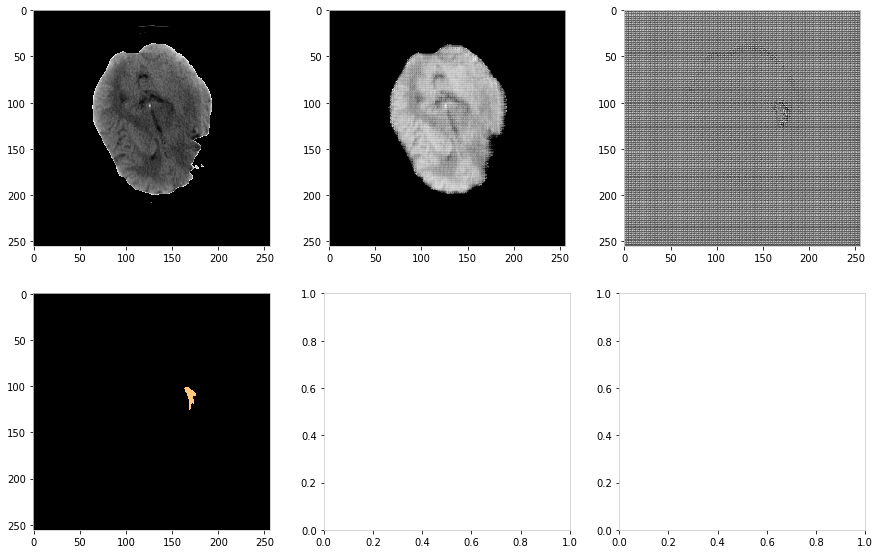

In [81]:
indice = 0

test_images_A = opt['A_train'][indice]
test_images_B = opt['B_train'][indice]

real_mask_A = opt['maskA_images'][indice]
real_mask_B = opt['maskB_images'][indice]

print(opt['trainA_image_names'][indice])
print(opt['A_train'].shape)
print(opt['B_train'].shape)
print(opt['maskA_images'].shape)
print(opt['maskB_images'].shape)

synthetic_images_B = model['G_A2B'].predict([test_images_A[np.newaxis,:], real_mask_B[np.newaxis,:]])
reconstructed_image_A = model['G_B2A'].predict([synthetic_images_B, real_mask_A[np.newaxis,:]])

synthetic_images_A = model['G_B2A'].predict([test_images_B[np.newaxis,:], real_mask_A[np.newaxis,:]])
reconstructed_image_B = model['G_A2B'].predict([synthetic_images_A, real_mask_B[np.newaxis,:]])

plt.figure(figsize=(15,20))
plt.subplot(4,3,1)
plt.imshow(test_images_A[:,:,0], cmap="gray")
#plt.imshow(real_mask_A[:,:,0], cmap="copper", alpha=0.2)
plt.subplot(4,3,2)
plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
#plt.imshow(real_mask_A[:,:,0], cmap="copper", alpha=0.2)
plt.subplot(4,3,3)
plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")

plt.subplot(4,3,4)
#plt.imshow(test_images_B[:,:,0], cmap="gray")
plt.imshow(real_mask_A[:,:,0], cmap="copper", alpha=1)
plt.subplot(4,3,5)
#plt.imshow(synthetic_images_A[0,:,:,0], cmap="gray")
plt.subplot(4,3,6)
#plt.imshow(reconstructed_image_B[0,:,:,0], cmap="gray")

In [82]:
import keras
import seaborn as sns

#.layers[-1].layers

capa_o = keras.models.Model(inputs=model["G_A2B"].layers[-1].get_input_at(0), outputs=model["G_A2B"].layers[-1].get_layer('UBlock1_EncoderBlock8-ReLU').output)
capa_o2 = keras.models.Model(inputs=model["G_B2A"].layers[-1].get_input_at(0), outputs=model["G_B2A"].layers[-1].get_layer('UBlock1_EncoderBlock8-ReLU').output)

In [83]:
#synthetic_B = model['G_A2B']([real_A, mask_A])
synthetic_images_B = model['G_A2B'].predict([opt['A_train'],opt['maskA_images']])

#synthetic_images_B_CTHEALTHY = model['G_A2B'].predict(opt['CTHEALTHY_images'])
#synthetic_images_B_CTFOSCAL = model['G_A2B'].predict(opt['CTFOSCAL_images'])

print(opt['trainA_image_names'][0])
#print(opt['CTHEALTHY_image_names'][0])
#print(opt['CTFOSCAL_image_names'][0])

emb = capa_o.predict(synthetic_images_B)
print("emb", emb[:,0,0,:].shape, emb.shape)

emb2 = capa_o2.predict(opt['B_train'])
print("emb2", emb2[:,0,0,:].shape)

#emb3 = capa_o2.predict(synthetic_images_B_CTHEALTHY)
#print("emb3", emb3[:,0,0,:].shape)

#emb4 = capa_o2.predict(synthetic_images_B_CTFOSCAL)
#print("emb4", emb4[:,0,0,:].shape)

339336-frame1.png
emb (502, 512) (502, 1, 1, 512)
emb2 (993, 512)


In [84]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
comp = pca.fit_transform(emb[:,0,0,:])

pca2 = PCA(n_components=2)
comp2 = pca2.fit_transform(emb2[:,0,0,:])

#pca3 = PCA(n_components=2)
#comp3 = pca3.fit_transform(emb3[:,0,0,:])

#pca4 = PCA(n_components=2)
#comp4 = pca4.fit_transform(emb4[:,0,0,:])

<class 'numpy.ndarray'>


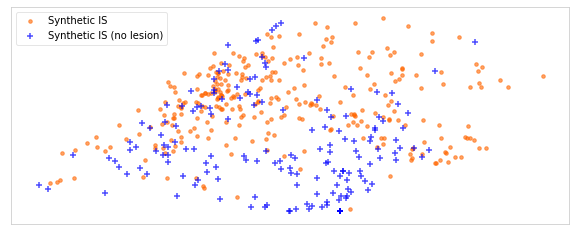

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

d = pd.read_csv("data/xxx2.csv")

mb_list = []
mb_synth_ns = []
mb_synth_stroke = []

print(type(comp))
for i in range(len(opt['trainA_image_names'])):
    #fname, comp[i,0], comp[i,1], maskbin
    mb_list.append(list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0])
    if (list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0]==0):
        mb_synth_ns.append([comp[i,0], comp[i,1]])
    else:
        mb_synth_stroke.append([comp[i,0], comp[i,1]])

mb_synth_ns = np.array(mb_synth_ns)
mb_synth_stroke = np.array(mb_synth_stroke)

d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
d = pd.DataFrame(data=d)

#sns.set(rc={'figure.figsize':(10,4)})
#sns.set_style("dark")
#sns.scatterplot(data=d, x="x_umap", y="y_umap", hue="maskbin", alpha=0.6)
#sns.reset_defaults()
plt.figure(figsize=(10,4))
plt.rcParams['axes.edgecolor'] = '#CCCCCC'

#plt.scatter(comp3[:,0], comp3[:,1], label="Synthetic Healthy", alpha=0.5, s=40, marker="+", color="#0000FF")
plt.scatter(mb_synth_stroke[:,0], mb_synth_stroke[:,1], label="Synthetic IS", alpha=0.6, s=50, marker=".", color="#FF6600")
plt.scatter(mb_synth_ns[:,0], mb_synth_ns[:,1], label="Synthetic IS (no lesion)", alpha=0.7, s=40, marker="+", color="#0000FF")

#plt.scatter(comp[:,0], comp[:,1], label="Synthetic MRI CTHEALTHY", alpha=0.8, s=5, color="#0000FF")
#plt.scatter(comp4[:,0], comp4[:,1], label="Synthetic MRI CTFOSCAL", alpha=0.8, s=5, color="#FF0000")
#plt.xticks(np.arange(-3, 20, 1))
plt.legend(framealpha=0.5)
plt.xticks([], [])
plt.yticks([], [])
#ax.xaxis.label.set_color('yellow')
#plt.savefig("plot01.pdf", bbox_inches="tight")
plt.savefig("plot-v3-masks-v1.pdf", bbox_inches="tight")
#plt.savefig("plot02.pdf", bbox_inches="tight")
plt.show()

In [ ]:
import cv2

#gray = real_mask_A[:,:,0]
print(opt['maskA_image_names'][indice])
a = "/home/gustavogarzon/code/cyclegan/cyclegan_tf/data/brain/maskA/"+opt['maskA_image_names'][indice]

img = cv2.imread(a)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

points = []
for c in range(len(contours[0])):
    points.append(contours[0][c][0])

points = np.array(points)

plt.plot(points[:,1], points[:,0])

In [ ]:
len(opt['maskA_images'])

In [ ]:
path1 = "/home/gustavogarzon/cyclegan/cyclegan_tf/data/brain/new/synthetic/"
path2 = "/home/gustavogarzon/cyclegan/cyclegan_tf/data/brain/new/reconstructed/"

for indice in range(len(opt['maskA_images'])):
    test_images_A = opt['A_train'][indice]
    real_mask_A = opt['maskA_images'][indice]
    real_mask_B = opt['maskB_images'][indice]
    fname = opt['trainA_image_names'][indice]
    
    synthetic_images_B = model['G_A2B'].predict([test_images_A[np.newaxis,:], real_mask_B[np.newaxis,:]])    
    #print(np.min(synthetic_images_B[0,:,:,0]), np.max(synthetic_images_B[0,:,:,0]))
    plt.imsave(path1+fname, synthetic_images_B[0,:,:,0], cmap="gray")
    plt.close()
    
    reconstructed_image_A = model['G_B2A'].predict([synthetic_images_B, real_mask_A[np.newaxis,:]])
    #print(np.min(reconstructed_image_A[0,:,:,0]), np.max(reconstructed_image_A[0,:,:,0]))
    plt.imsave(path2+fname, reconstructed_image_A[0,:,:,0], cmap="gray")
    plt.close()
    #break